In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# %tensorflow_version only exists in Colab.
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks

import os
import pathlib
import numpy as np
import pandas as pd
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image


print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__) 

Num GPUs Available:  1
Tensorflow version:  2.1.0


#Dataset Import and Overview

In [58]:
np.random.seed(101)
tf.random.set_seed(101)


LABELS_FILE = "/content/drive/My Drive/dogs/train_labels.csv"

df = pd.read_csv(LABELS_FILE)
print(df.head())

CLASS_NAMES = np.unique(df.breed)
BREED_COUNT = 63
class_count = len(CLASS_NAMES)

data_dir = "/content/drive/My Drive/dogs/Dataset/train"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

                                 id               breed
0  a32893132f6fbb3635df77c157c7d8e0  scottish_deerhound
1  3b3ae8c92f704bf449ea4bc61866461b  scottish_deerhound
2  c9bbc4ce586c0d73e14bee1b1e674ba9  scottish_deerhound
3  f194e48d99e5e0f279eb8cd5e6872e36  scottish_deerhound
4  03dc61595ad9dbf49e3998cf586ca8cb  scottish_deerhound
Number of images: 2205


#Image Loading

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count * 0.7 / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [60]:
# get a dataset of all files matching the pattern
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/My Drive/dogs/Dataset/train/norwegian_elkhound/d9483ad58c5e1ae2e73ac0de09aac90d.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/border_terrier/5501faf6694477c31ea97dede096154c.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/lhasa/4b3f4c910479686b10d676f813da0b3f.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/beagle/58154ab6841198957a50526106c72d72.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/pembroke/4792cc9e614c5aa380ce532a2b182e16.jpg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label  

In [62]:
# apply process_path function to each element of this dataset, and return a new
# dataset containing the transformed elements, in the same order as they 
# appeared in the input.
# set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(3):
  #print("Image tensor: ", image)
  #print("Label tensor:", label)
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label)

Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)


# Data Preparation

In [0]:
def breed_distr(ds):
  for breed in CLASS_NAMES:
    count = 0
    for element in ds.as_numpy_iterator(): 
      label = CLASS_NAMES[element[1] == 1][0]
      if (breed in label):
        count += 1
    print(breed, count)


def split_ds(ds, ds_size, split, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  val_size = np.floor(ds_size * split)
  val_ds = ds.take(val_size)
  train_ds = ds.skip(val_size)
  
  return (train_ds, val_ds)


def prepare_for_training(ds, cache=True):
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
      ax = plt.subplot(5, 5, n + 1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
      plt.axis('off')

In [71]:
train_ds, val_ds = split_ds(labeled_ds, image_count, 0.3,
                                        cache="./dogs.tfcache")
#breed_distr(train_ds)
#breed_distr(val_ds)

train_ds = prepare_for_training(train_ds, cache="./dogs_train.tfcache")
val_ds = val_ds.batch(BATCH_SIZE)


print(train_ds)
print(val_ds)
print(train_ds.element_spec)
print(val_ds.element_spec)

afghan_hound 39
airedale 44
australian_terrier 48
basenji 47
beagle 49
bernese_mountain_dog 51
blenheim_spaniel 45
border_terrier 43
cairn 45
chow 47
entlebucher 49
great_pyrenees 44
ibizan_hound 41
irish_wolfhound 46
italian_greyhound 45
japanese_spaniel 47
lakeland_terrier 41
leonberg 42
lhasa 36
maltese_dog 42
miniature_pinscher 43
newfoundland 47
norwegian_elkhound 46
papillon 40
pembroke 40
pomeranian 43
pug 44
saluki 44
samoyed 46
scottish_deerhound 41
shih-tzu 43
siberian_husky 45
silky_terrier 50
tibetan_terrier 39
whippet 41
afghan_hound 19
airedale 24
australian_terrier 18
basenji 13
beagle 23
bernese_mountain_dog 19
blenheim_spaniel 19
border_terrier 26
cairn 19
chow 18
entlebucher 12
great_pyrenees 17
ibizan_hound 21
irish_wolfhound 22
italian_greyhound 17
japanese_spaniel 16
lakeland_terrier 15
leonberg 15
lhasa 16
maltese_dog 19
miniature_pinscher 19
newfoundland 20
norwegian_elkhound 19
papillon 19
pembroke 30
pomeranian 22
pug 18
saluki 17
samoyed 24
scottish_deerhound 

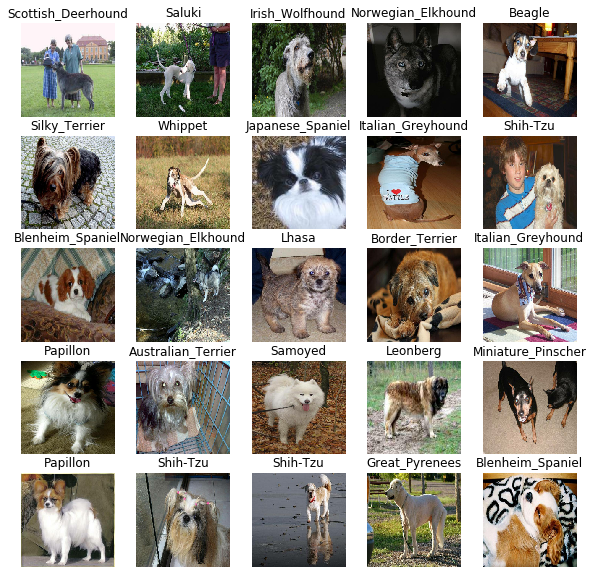

In [10]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [19]:
timeit(train_ds)

....................................................................................................
1000 batches: 302.08218359947205 s
105.93144 Images/s


# Model

In [72]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(class_count, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [73]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5)

history = model.fit(train_ds, 
                    epochs=10,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=val_ds,
                    steps_per_epoch=STEPS_PER_EPOCH
                    )

Train for 49.0 steps, validate for 21 steps
Epoch 1/10
49/49 [==============================] - 9s 187ms/step - loss: 3.8700 - accuracy: 0.0344 - val_loss: 3.5554 - val_accuracy: 0.0227
Epoch 2/10
49/49 [==============================] - 2s 47ms/step - loss: 3.5553 - accuracy: 0.0332 - val_loss: 3.5554 - val_accuracy: 0.0257
Epoch 3/10
49/49 [==============================] - 2s 47ms/step - loss: 3.5606 - accuracy: 0.0357 - val_loss: 3.5549 - val_accuracy: 0.0333
Epoch 4/10
49/49 [==============================] - 2s 47ms/step - loss: 3.5536 - accuracy: 0.0300 - val_loss: 3.5429 - val_accuracy: 0.0454
Epoch 5/10
49/49 [==============================] - 2s 48ms/step - loss: 3.5462 - accuracy: 0.0446 - val_loss: 3.5147 - val_accuracy: 0.0530
Epoch 6/10
49/49 [==============================] - 2s 50ms/step - loss: 3.4793 - accuracy: 0.0721 - val_loss: 3.4109 - val_accuracy: 0.1044
Epoch 7/10
49/49 [==============================] - 2s 49ms/step - loss: 3.0566 - accuracy: 0.1830 - val_loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


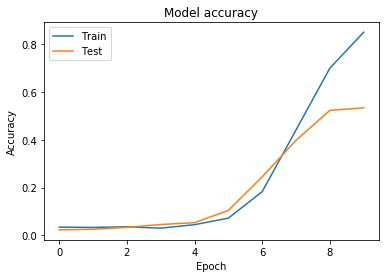

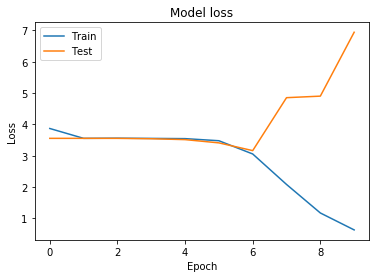

In [77]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [74]:
loss, accuracy = model.evaluate(val_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)


21/21 [==============================] - 1s 37ms/step - loss: 6.6206 - accuracy: 0.5356
Loss : 6.620637825557163
Accuracy : 0.5355522
